In [1]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [5]:
input_shape = 224, 224, 3
n_classes = 5

K.clear_session()
model = densenet(input_shape, n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

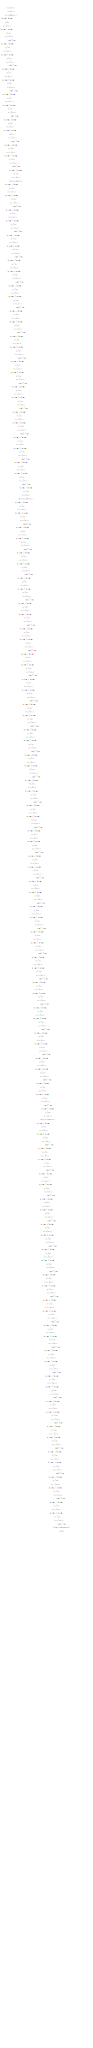

In [6]:

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
import os

import numpy as np
from keras.utils import np_utils
from keras import backend as K
from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file


In [8]:
imagePaths = sorted(list(os.listdir("/content/drive/MyDrive/Colab Notebooks/DATA(VGG-19)/train2.0")))
print(imagePaths)

['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']


In [16]:
for img in imagePaths:
    path=sorted(list(os.listdir("/content/drive/MyDrive/Colab Notebooks/DATA(VGG-19)/train2.0/"+img)))
    print(path)

['ADNI_002_S_4229_MR_Axial_T2-Star__br_raw_20151208115458310_22_S325498_I573624.jpg', 'ADNI_002_S_4229_MR_Axial_T2_STAR__br_raw_20170921122709574_22_S610930_I906802.jpg', 'ADNI_002_S_4229_MR_Axial_T2_STAR__br_raw_20180920102955004_22_S728699_I1050348.jpg', 'ADNI_002_S_4521_MR_Axial_T2-Star__br_raw_20150507104805054_22_S258648_I491174.jpg', 'ADNI_002_S_4654_MR_Axial_T2-Star__br_raw_20160420150257741_22_S424505_I687385.jpg', 'ADNI_002_S_4654_MR_Axial_T2_STAR__br_raw_20170505115551172_22_S562123_I848002.jpg', 'ADNI_002_S_4654_MR_Axial_T2_STAR__br_raw_20180524095619851_22_S689132_I1001981.jpg', 'ADNI_002_S_4654_MR_Axial_T2_STAR__br_raw_20180524095619996_22_S689131_I1001980.jpg', 'ADNI_003_S_4354_MR_Axial_T2_STAR__br_raw_20170623130136657_22_S574600_I863646.jpg', 'ADNI_003_S_4354_MR_Axial_T2_STAR__br_raw_20190627123527317_22_S836975_I1181463.jpg', 'ADNI_003_S_4354_MR_Axial_T2_STAR__raw_20181219164830148_22_S762851_I1091958.jpg', 'ADNI_003_S_4354_MR_Axial_T2_Star__br_raw_20160212152304887_22

In [9]:
from sklearn.preprocessing import LabelBinarizer
import cv2
import random
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split   


In [10]:
def load_data():
  data=[]
  labels=[]
  random.seed(42)
  imagePaths = sorted(list(os.listdir("/content/drive/MyDrive/Colab Notebooks/DATA(VGG-19)/train2.0")))
  # random.shuffle(imagePaths)
  print(imagePaths)

  for img in imagePaths:
    path=sorted(list(os.listdir("/content/drive/MyDrive/Colab Notebooks/DATA(VGG-19)/train2.0/"+img)))
    for i in path:
        image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/DATA(VGG-19)/train2.0/"+img+'/'+i)
        image = cv2.resize(image, (224,224))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)
  data = np.array(data, dtype="float32") / 255.0
  labels = np.array(labels)
  mlb = LabelBinarizer()
  labels = mlb.fit_transform(labels)

  (xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.25,random_state=42)
  print(xtrain.shape, xtest.shape)
  return xtrain, ytrain, xtest, ytest



In [11]:
load_data()

['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
(615, 224, 224, 3) (205, 224, 224, 3)


(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

In [12]:
from keras.callbacks import ModelCheckpoint
if __name__ == '__main__':

    # Example to fine-tune on 3000 samples from Cifar10

    img_rows, img_cols = 224, 224 # Resolution of inputs
    channel = 3
    num_classes =4
    batch_size = 16 
    # nb_epoch = 10

    # Load Cifar10 data. Please implement your own load_data() module for your own dataset
    X_train, Y_train, X_valid, Y_valid = load_data()

    # Load our model
    model = densenet(input_shape, n_classes)
    filepath="bestmodel.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Start Fine-tuning
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history=model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=10,
              shuffle=True,
              verbose=1,
              validation_data=(X_valid, Y_valid),
              callbacks=callbacks_list,
              )

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # Cross-entropy loss score
    score = log_loss(Y_valid, predictions_valid)

['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']
(615, 224, 224, 3) (205, 224, 224, 3)
Epoch 1/10
39/39 [==============================] - ETA: 0s - loss: 2.5694 - accuracy: 0.4130 

39/39 [==============================] - 603s 14s/step - loss: 2.5694 - accuracy: 0.4130 - val_loss: 295.9395 - val_accuracy: 0.0439
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 1.5129 - accuracy: 0.4618 

39/39 [==============================] - 547s 14s/step - loss: 1.5129 - accuracy: 0.4618 - val_loss: 1.3481 - val_accuracy: 0.5024
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 1.5973 - accuracy: 0.4699 

39/39 [==============================] - 531s 14s/step - loss: 1.5973 - accuracy: 0.4699 - val_loss: 12.6341 - val_accuracy: 0.1902
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 1.4428 - accuracy: 0.4911 

39/39 [==============================] - 546s 14s/step - loss: 1.4428 - accuracy: 0.4911 - val_loss: 1.4241 - val_accuracy: 0.4439
Epoch 5/10
39/39 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.4911 

39/39 [==============================] - 543s 14s/step - loss: 1.4594 - accuracy: 0.4911 - val_loss: 1.3871 - val_accuracy: 0.5024
Epoch 6/10
39/39 [==============================] - ETA: 0s - loss: 1.4709 - accuracy: 0.4862 

39/39 [==============================] - 542s 14s/step - loss: 1.4709 - accuracy: 0.4862 - val_loss: 2.8918 - val_accuracy: 0.3610
Epoch 7/10
39/39 [==============================] - ETA: 0s - loss: 1.4294 - accuracy: 0.4797 

39/39 [==============================] - 524s 13s/step - loss: 1.4294 - accuracy: 0.4797 - val_loss: 790.6639 - val_accuracy: 0.5024
Epoch 8/10
39/39 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.5089 

39/39 [==============================] - 542s 14s/step - loss: 1.3746 - accuracy: 0.5089 - val_loss: 11.8576 - val_accuracy: 0.1024
Epoch 9/10
39/39 [==============================] - ETA: 0s - loss: 1.3736 - accuracy: 0.5041 

39/39 [==============================] - 530s 14s/step - loss: 1.3736 - accuracy: 0.5041 - val_loss: 1.9486 - val_accuracy: 0.5024
Epoch 10/10
39/39 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.5057 

13/13 [==============================] - 35s 2s/step


NameError: ignored

<Figure size 500x500 with 0 Axes>

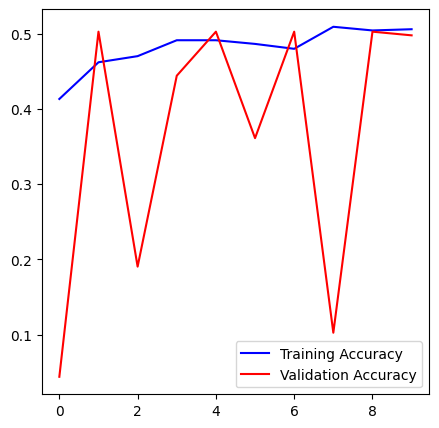

<Figure size 640x480 with 0 Axes>

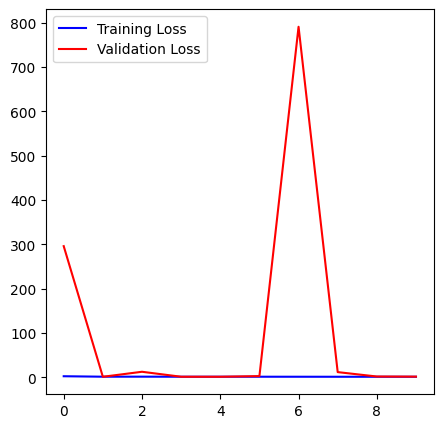

In [17]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
plt.figure(figsize=(5, 5))
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.figure(figsize=(5, 5))
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()

In [18]:
#X_valid, Y_valid
xtest=X_valid
ytest=Y_valid
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

7/7 [==============================] - 36s 5s/step
Total-test-data; 205 	accurately-predicted-data: 102 	 wrongly-predicted-data:  103
Accuracy: 49.756 %
